In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
from scipy.optimize import minimize,Bounds

warnings.filterwarnings('ignore')


In [2]:
ajax_2018 = pd.read_csv('AjaxData.csv')
ajax_2018.tail()

,Unnamed: 0,Day,Hr,ActFrcst,GenFrac,Date
5227,5228,105,24,2,0.681881,2017-06-01
5228,5229,106,24,2,0.527580,2017-06-02
5229,5230,107,24,2,0.167005,2017-06-03
5230,5231,108,24,2,0.287933,2017-06-04
5231,5232,109,24,2,0.333945,2017-06-05


In [3]:
actual = ajax_2018.loc[ajax_2018['ActFrcst']==1,['Hr','GenFrac','Date']]
actual.reset_index(drop = True,inplace=True)
actual

,Hr,GenFrac,Date
0,1,0.000000,2017-02-17
1,1,0.330527,2017-02-18
2,1,0.950428,2017-02-19
3,1,0.984216,2017-02-20
4,1,0.632875,2017-02-21
...,...,...,...
2611,24,0.956100,2017-06-01
2612,24,0.915442,2017-06-02
2613,24,0.670460,2017-06-03
2614,24,0.779140,2017-06-04


In [4]:
forecast = ajax_2018.loc[ajax_2018['ActFrcst']==2,['Hr','GenFrac','Date']]
forecast.reset_index(drop = True,inplace=True)
forecast

,Hr,GenFrac,Date
0,1,0.025694,2017-02-17
1,1,0.116288,2017-02-18
2,1,0.976293,2017-02-19
3,1,0.888559,2017-02-20
4,1,0.570631,2017-02-21
...,...,...,...
2611,24,0.681881,2017-06-01
2612,24,0.527580,2017-06-02
2613,24,0.167005,2017-06-03
2614,24,0.287933,2017-06-04


In [5]:
f"Number of days: {len(forecast['Date'].unique())}"

'Number of days: 109'

Text(0.5, 1.0, 'April 12')

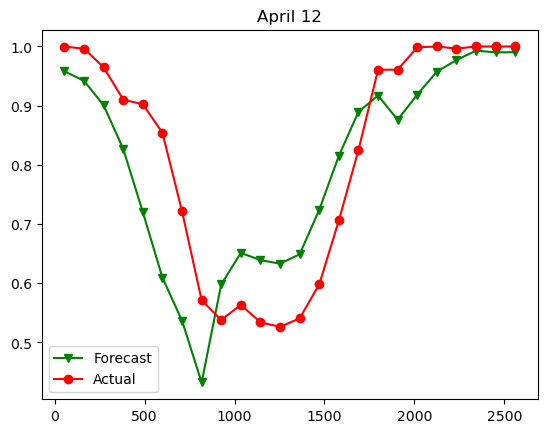

In [6]:
plt.plot(forecast.loc[forecast['Date'].str.contains('2017-04-12'),:]['GenFrac'],color = "green", marker = "v")
plt.plot(actual.loc[actual['Date'].str.contains('2017-04-12'),:]['GenFrac'],color = "red", marker = "o")
plt.legend(['Forecast','Actual'])
plt.title("April 12")

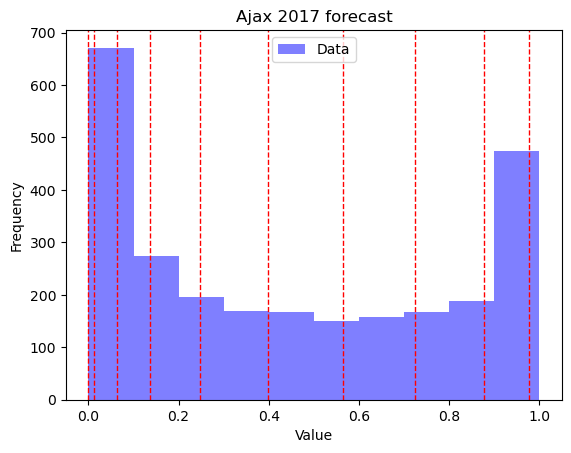

In [7]:

# Creating 10 bins for the 'Amazon Wind Farm Texas' column
bins = pd.qcut(actual['GenFrac'], q=10,duplicates='drop',precision=20)
# Plot histogram with quantiles
plt.hist(actual['GenFrac'], bins=10, alpha=0.5, color='blue', label='Data')
for q in bins.unique():
    plt.axvline(q.left, color='red', linestyle='--', linewidth=1)
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Ajax 2017 forecast')
plt.legend()
plt.show()


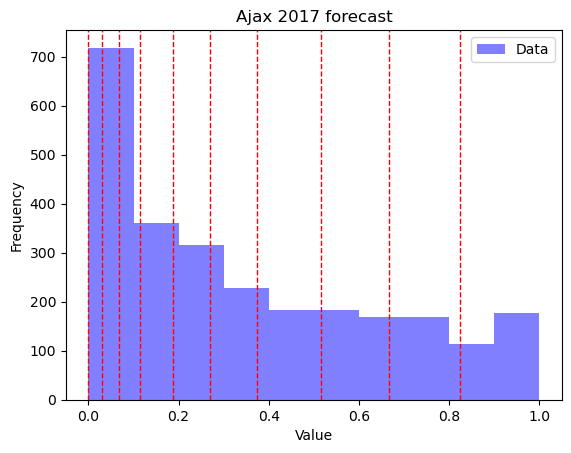

In [8]:


# Creating 10 bins for the 'Amazon Wind Farm Texas' column
bins = pd.qcut(forecast['GenFrac'], q=10,duplicates='drop',precision=20)
# Plot histogram with quantiles
plt.hist(forecast['GenFrac'], bins=10, alpha=0.5, color='blue', label='Data')
for q in bins.unique():
    plt.axvline(q.left, color='red', linestyle='--', linewidth=1)
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Ajax 2017 forecast')
plt.legend()
plt.show()



 Historical data to create 10 quantile bins.
 Based on forecast of hour, see which bin it belongs to, use sigma, b for that bin. I.e; all the historical observations in that hour regardless of where they are should go to f_h.
 Then, perform residual minimizaiton

In [9]:
for i in range(10):
    
    bin_lower = bins.cat.categories[i].left
    bin_upper = bins.cat.categories[i].right
    wind_amzn = forecast.loc[(forecast['GenFrac']>bin_lower) & (forecast['GenFrac'] <=bin_upper),['GenFrac']]
    print(f"Bin LB: { bin_lower}, Bin UB: {bin_upper} ")
    print("Observations in bin" + str(i+1) + ": "+str(wind_amzn.shape[0])+ "\n")

Bin LB: -1e-20, Bin UB: 0.030783324780023998 
Observations in bin1: 262

Bin LB: 0.030783324780023998, Bin UB: 0.0672197343290153 
Observations in bin2: 262

Bin LB: 0.0672197343290153, Bin UB: 0.11357845079418503 
Observations in bin3: 261

Bin LB: 0.11357845079418503, Bin UB: 0.18851874580774303 
Observations in bin4: 262

Bin LB: 0.18851874580774303, Bin UB: 0.269714329816163 
Observations in bin5: 261

Bin LB: 0.269714329816163, Bin UB: 0.37455341250279417 
Observations in bin6: 262

Bin LB: 0.37455341250279417, Bin UB: 0.515699462710831 
Observations in bin7: 261

Bin LB: 0.515699462710831, Bin UB: 0.665413447743709 
Observations in bin8: 262

Bin LB: 0.665413447743709, Bin UB: 0.823734255597393 
Observations in bin9: 261

Bin LB: 0.823734255597393, Bin UB: 0.999783271891574 
Observations in bin10: 262



Now, let's say you have jacobi type diffusion $\sigma X_t (1- X_t)$, then to calibrate  

# Regress $\frac{X_{t+1} - X_{t} }{ X_t (1-X_t) \sqrt{dt}}$ against  $\frac{m_t - X_t} {X_t (1-X_t)}  \sqrt{dt}$ with Var($\epsilon$) = $\sigma^2$. 

The issue is that division by 0 when X is 0 or 1. 

Quick fix: Replace by nearest value. 

However, this explodes variance of residuals.

Quick fix: Remove outlier using z-score and compute std. 

Can try regularized regression as well.

In [10]:
from collections import defaultdict
import numpy as np 
mean_rev_dics = defaultdict(float)
sigma_dics = defaultdict(float)
residuals_dic = defaultdict(np.ndarray)


In [11]:
dt = 1/24
import statsmodels.api as sm
from scipy.stats import median_abs_deviation
def b_sigma_estimator(bin_idx):
    bin_lower= bins.cat.categories[bin_idx].left
    bin_upper = bins.cat.categories[bin_idx].right

    forecast_in_bin =  forecast.loc[(forecast['GenFrac']>bin_lower) & (forecast['GenFrac'] <=bin_upper),['GenFrac']].to_numpy().flatten()

    actual_in_bin = actual.loc[(forecast['GenFrac']>bin_lower) & (forecast['GenFrac'] <=bin_upper),['GenFrac']].to_numpy().flatten()

    # Replace too small or too big values, band width 95% 


    actual_in_bin[actual_in_bin<0.05] = 0.05
    actual_in_bin[actual_in_bin >0.95] = 0.95
    
    # Prepare for regression
    responses = (actual_in_bin[1:] - actual_in_bin[:-1])/ ( actual_in_bin[:-1] * (1-actual_in_bin[:-1]) * np.sqrt(dt)) 
    predictors = (forecast_in_bin[:-1] - actual_in_bin[:-1]) * np.sqrt(dt)/( actual_in_bin[:-1] * (1- actual_in_bin[:-1]))
    predictors =  predictors
    print(responses.shape,predictors.shape)

    # Define and fit the model
    Y = responses
    X = predictors.reshape(-1,1)
    model = sm.OLS(Y, X)
    results = model.fit()
    
    # Clean up residuals

    residuals = results.resid

    z_scores = np.abs((residuals - np.mean(residuals)) / np.std(residuals))
    threshold = 3 # 95% z score
    outlier_indices = np.where(z_scores > threshold)
    cleaned_residuals_z = np.delete(residuals, outlier_indices)
    mean_rev_rate = results.params[0]
    sigma = np.std(cleaned_residuals_z)
    #sigma =  median_abs_deviation(cleaned_residuals_z)

    mean_rev_dics[bin_idx] = mean_rev_rate
    sigma_dics[bin_idx] = sigma
    residuals_dic[bin_idx] = cleaned_residuals_z
    return mean_rev_rate,sigma


In [12]:
for i in range(10):
    print(b_sigma_estimator(i))

(261,) (261,)
(-1.5047708875291481, 1.4528662177011917)
(261,) (261,)
(10.771365395858545, 5.150946717699352)
(260,) (260,)
(24.82753453363021, 6.787168545023447)
(261,) (261,)
(19.018434273961642, 5.998750280189701)
(260,) (260,)
(14.368000670309428, 5.638702681166949)
(261,) (261,)
(14.864484677513161, 6.077730738673784)
(260,) (260,)
(10.65480937765728, 5.632157841933755)
(261,) (261,)
(11.290660111456987, 7.345799018701952)
(260,) (260,)
(11.805991107633186, 8.121309326428152)
(261,) (261,)
(16.677729838357227, 5.150048187335852)


Text(0.5, 1.0, '$\\hat{\\alpha}$  by Bin')

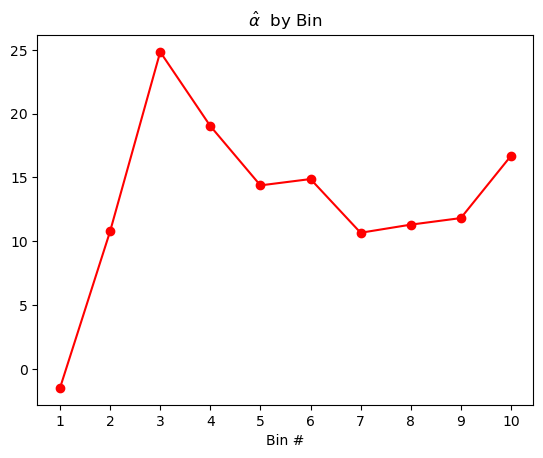

In [13]:
plt.plot(np.linspace(1,10,10),mean_rev_dics.values(),color = "red",marker = "o")
plt.xticks(np.linspace(1,10,10))
plt.xlabel("Bin #")
plt.title(r"$\hat{\alpha}$  by Bin")

Text(0.5, 1.0, '$\\hat{\\sigma}$  by Bin')

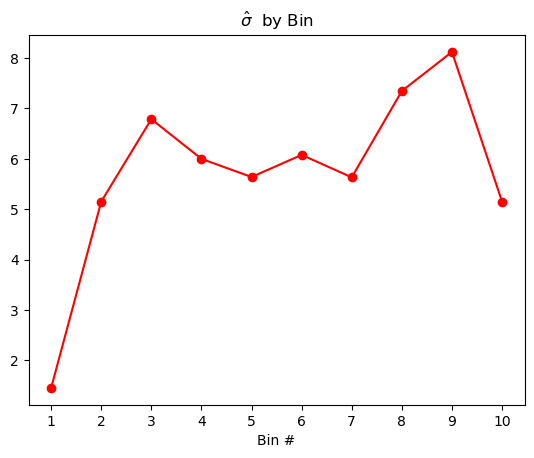

In [14]:
plt.plot(np.linspace(1,10,10),sigma_dics.values(),color = "red",marker = "o")
plt.xticks(np.linspace(1,10,10))
plt.xlabel("Bin #")
plt.title(r"$\hat{\sigma}$  by Bin")

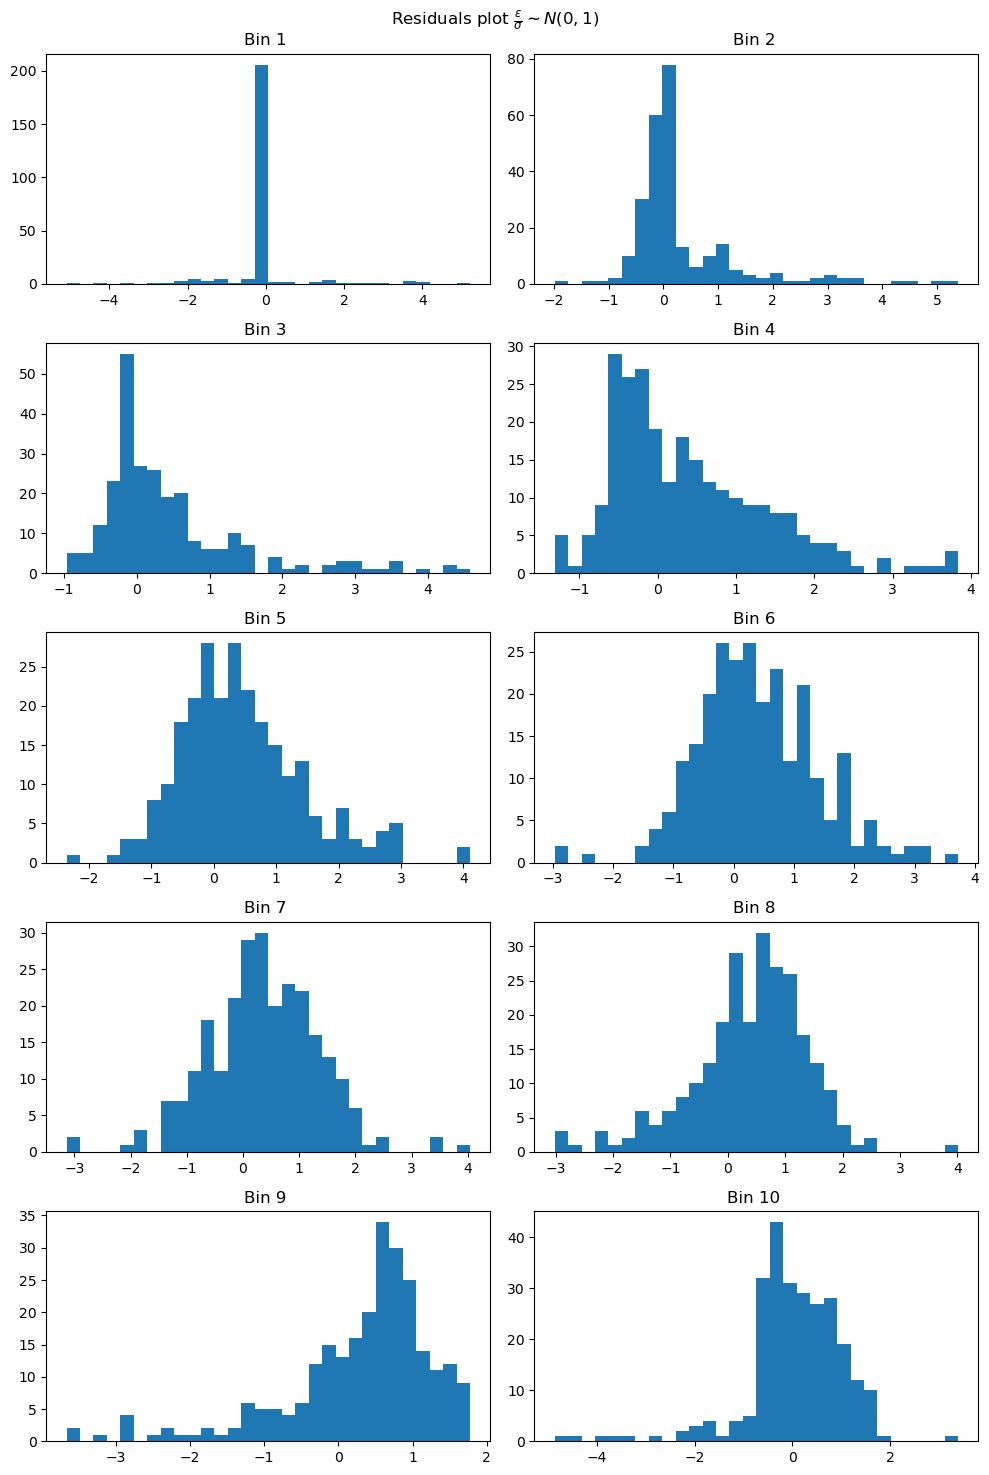

In [15]:
fig, axs = plt.subplots(5, 2, figsize=(10, 15))

# Flatten the axs array to make it easier to iterate over
axs = axs.flatten()

# Plot each subplot
for i in range(10):
    axs[i].hist(residuals_dic[i]/np.std(residuals_dic[i]),bins = 30)
    axs[i].set_title(f'Bin {i+1} ')

# Adjust layout to prevent overlap of titles
plt.suptitle(r"Residuals plot $\frac{\epsilon}{\sigma} \sim N(0,1) $")
plt.tight_layout()

# Show the plot
plt.show()

## In the next step, we will test on April 12 data
### Select sequence of $\sigma_{hat}$ and $\alpha_{hat}$ by forecast bin for each hour.
### Simulate SDE and report CI.


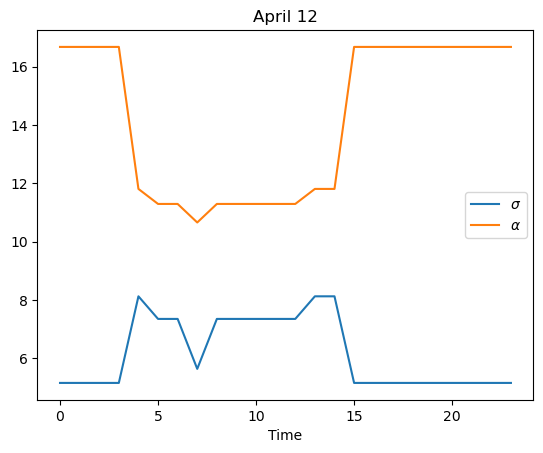

In [16]:
aprl_frcast = forecast.loc[forecast['Date'].str.contains('2017-04-12'),:]['GenFrac'].to_numpy()
aprl_act = actual.loc[actual['Date'].str.contains('2017-04-12'),:]['GenFrac'].to_numpy()
sigmas = np.zeros(24)
mean_rates = np.zeros(24)
for i in range(24):
    idx = bins.cat.categories.get_indexer([aprl_frcast[i]])[0]
    sigmas[i] = sigma_dics[idx]
    mean_rates[i] = mean_rev_dics[idx]


plt.plot(sigmas,label = r"$\sigma$")
plt.plot(mean_rates,label = r"$\alpha$")
plt.title("April 12")
plt.xlabel("Time")
plt.legend()

# SDE with white noise

In [17]:

dt = 1/24

W = np.random.normal(0,1,size = (10000,24) )
Xs = np.zeros((10000,25))

Xs[:,0]= np.minimum(np.random.normal(aprl_frcast[0],0.05,size = (10000) ),1)

for i in range(1,25):
    
    Xs[:,i] = np.abs(Xs[:,i-1] + ( mean_rates[i-1] * (aprl_frcast[i-1]- Xs[:,i-1]) * dt  ) + sigmas[i-1] * ( (Xs[:,i-1]) * (1-Xs[:,i-1]) ) * W[:,i-1] *np.sqrt(dt))

    Xs[:,i] = np.minimum(Xs[:,i],1)
    Xs[:,i] = np.maximum(Xs[:,i],0)


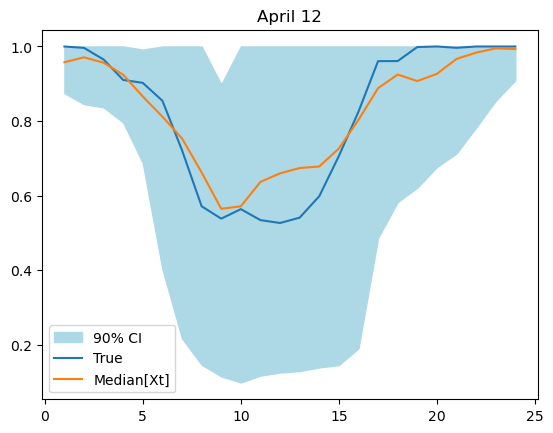

In [18]:
# Calculate the quantiles (0.005 and 0.995 for 99% CI)
lower_quantile = np.quantile(Xs, 0.05, axis=0)[:-1]
upper_quantile = np.quantile(Xs, 0.95, axis=0)[:-1]
preds = np.quantile(Xs, 0.50, axis=0)[:-1]
# Plotting
plt.fill_between(np.arange(1,25), lower_quantile, upper_quantile, color='lightblue', label='90% CI')
#plt.plot(np.arange(1,25),aprl_frcast,label = "Forecast")
plt.plot(np.arange(1,25),aprl_act,label = "True")
plt.plot(np.arange(1,25),preds, label = "Median[Xt]")
plt.title("April 12")
plt.legend()

# SDE with boostrap

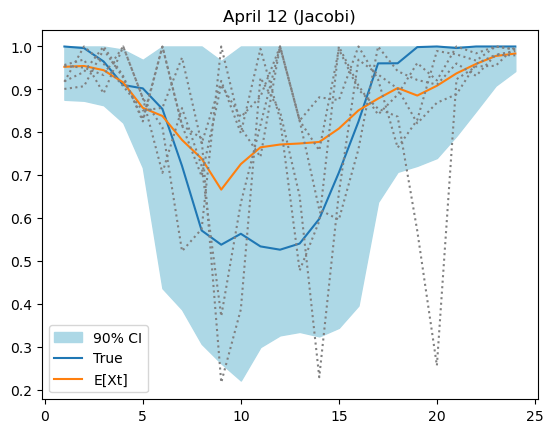

In [19]:

dt = 1/24

W = np.random.normal(0,1,size = (10000,24) )
Xs = np.zeros((10000,25))

Xs[:,0]= np.minimum(np.random.normal(aprl_frcast[0],0.05,size = (10000) ),1)

for i in range(1,25):
    idx = bins.cat.categories.get_indexer([aprl_frcast[i-1]])[0]
    #data = (residuals_dic[idx],)  # samples must be in a sequence
    #sigmas = bootstrap(data, np.std, confidence_level=0.95,n_resamples=10000).bootstrap_distribution

    noises = np.random.choice(residuals_dic[idx]/sigma_dics[idx]  ,size=10000, replace = True)

    #Xs[:,i] = np.abs(Xs[:,i-1] + ( mean_rates[i-1] * (aprl_frcast[i-1]- Xs[:,i-1]) * dt  ) +sigmas* ( (Xs[:,i-1]) * (1-Xs[:,i-1]) ) *np.sqrt(dt) * W[:,i-1])
    Xs[:,i] = np.abs(Xs[:,i-1] + ( mean_rates[i-1] * (aprl_frcast[i-1]- Xs[:,i-1]) * dt  ) + sigma_dics[idx] * noises* ( (Xs[:,i-1]) * (1-Xs[:,i-1]) ) *np.sqrt(dt))
    Xs[:,i] = np.minimum(Xs[:,i],1)
    Xs[:,i] = np.maximum(Xs[:,i],0)

# Calculate the quantiles (0.005 and 0.995 for 99% CI)
lower_quantile = np.quantile(Xs, 0.05, axis=0)[:-1]
upper_quantile = np.quantile(Xs, 0.95, axis=0)[:-1]
preds = np.mean(Xs,axis=0)[:-1]

plt.fill_between(np.arange(1,25), lower_quantile, upper_quantile, color='lightblue', label='90% CI')
#plt.plot(np.arange(1,25),aprl_frcast,label = "Forecast")
plt.plot(np.arange(1,25),aprl_act,label = "True")
plt.plot(np.arange(1,25),preds, label = "E[Xt]")


for i in range(5):
    plt.plot(np.arange(1,25),Xs[i+10,:-1], linestyle='dotted', color='grey')
plt.title("April 12 (Jacobi)")
plt.title("April 12 (Jacobi)")
plt.legend()

In [66]:
import RMC
X0 = np.minimum(np.random.normal(aprl_frcast[0],0.05,size = (10000) ),1)
sigmas = np.zeros(24)
noises=  np.zeros((10000,24))
for i in range(24):

    idx = bins.cat.categories.get_indexer([aprl_frcast[i-1]])[0]
    sigmas[i] = sigma_dics[idx]
    noises[:,i] =   np.random.choice(residuals_dic[idx]/sigma_dics[idx]  ,size=10000, replace = True)
process = RMC.simulate.Jacobi(X0,24,10000,1,mean_rates,aprl_frcast,sigmas,1,0,noises)

running_cost = RMC.costfunctions.L2()
final_cost = RMC.costfunctions.final_SOCcontraint(0.1,0)
parameters = (0.5,1,0.95,0.05)
batch_size = 50
value_kernel= None
normalize_v = True
policy_kernel = None
normalize_policy = True
hybrid_solution = RMC.model.HybridControl(600,process,running_cost,final_cost,parameters,batch_size,\
                                          value_kernel,normalize_v,policy_kernel,normalize_policy)

hybrid_solution.X_lowers = np.ones(25)*0
hybrid_solution.X_uppers= np.ones(25)*1

hybrid_solution.solve()

Policy GP MSE: 9.102115890844742e-17
Value GP MSE: 2.3362704109658252e-08
Timestep: 0.9583333333333333
__________________________________________________
Policy GP MSE: 1.3677269747692252e-10
Value GP MSE: 3.647332988455899e-09
Timestep: 0.9166666666666666
__________________________________________________


A bit complicated behavior is happening with optimal control

When $X_t>M_t$, $B_t$ will charge resuling $O_t$ close to $M_t$. Will $B_t$ ever discharge and make $O_t > X_t> M_t$ ,causing extra curtailment? The answer is it's possible when $I_t$ is too high already. If we care this, we can add constraint on $B$ manually. We dont for now

OTOH, 
When $X_t<M_t$, $B_t$ will discharge resuling $O_t$ close to $M_t$. Will $B_t$ ever charge and make $O_t < X_t < M_t$ cause extra power shortage. The answer is it's possible when $I_t$ is too low already. We care this! We will add the constrait during optimization/training and testing.

So,Check where $X_t < M_t$.  Intersect where $X_t < M_t$ but $B_t$ is charging. Make sure it is 0. Otherwise, $X_t - B_t <X_t < M_t$ and we dont like that

In addition when charging $X_t>M_t$, make sure u dont overcharge and fall below $M_t$, causing shortage when you are guarenteed $O_t>M_t$.

We do not care discharging for both cases. You can discharge in first case and cause extra curtailment. You can also discharge more than needed in second case and cause extra curtailment.

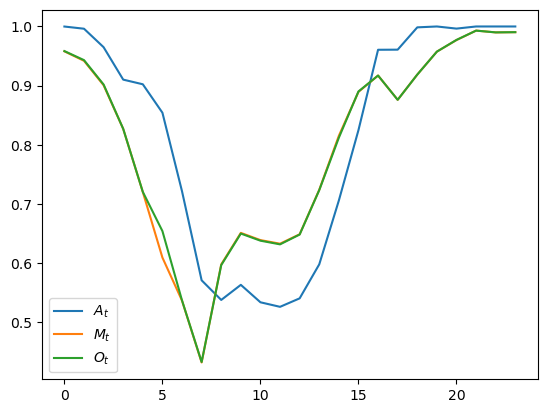

In [56]:


X_vec = aprl_act
I_vec = np.zeros(len(X_vec)+1)
I_vec[0] = 0.1
B_vec = np.zeros(len(X_vec))
total_cost = 0
for i in range(24):
    cur_X =  X_vec[i]
    cur_I  = I_vec[i]
    inp_vec = np.array([cur_X,cur_I]).reshape(1,-1)
    B = hybrid_solution.policy_maps[i].predict(inp_vec)[0].flatten()

    if cur_X-hybrid_solution.targets[i] <0 and B >0:
        B= 0
    if B>0:
        B = np.minimum(cur_X-hybrid_solution.targets[i],B)
    LB = np.maximum(hybrid_solution.Bmin,hybrid_solution.charging_eff*(hybrid_solution.Ilb- cur_I)/hybrid_solution.dt)
    UB = np.minimum(hybrid_solution.Bmax,(hybrid_solution.Iub-cur_I)/(hybrid_solution.charging_eff*hybrid_solution.dt))
    B = np.maximum(LB,np.minimum(B,UB))

    B_vec[i] = B
    cur_I = cur_I + B * ( (B>0) * hybrid_solution.charging_eff + (B<0) *1/hybrid_solution.charging_eff) * hybrid_solution.dt
    total_cost = total_cost+ hybrid_solution.running_cost.cost(B,cur_X,hybrid_solution.targets[i])* process.dt
    I_vec[i+1]=cur_I

plt.plot(X_vec)
plt.plot(hybrid_solution.targets)
plt.plot(X_vec-B_vec)
plt.legend([r"$A_t$",r"$M_t$",r"$O_t$"])


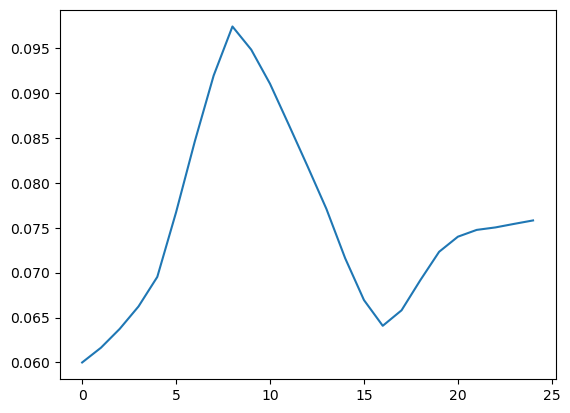

In [57]:
plt.plot(I_vec)

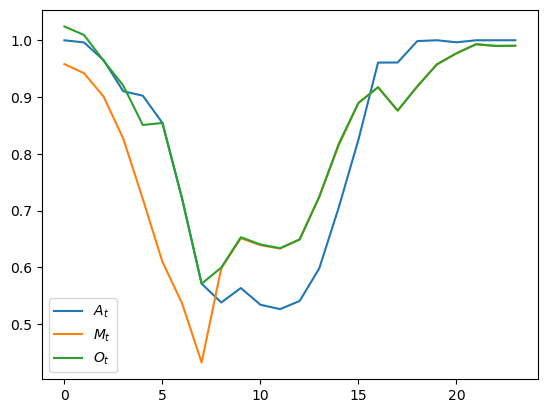

In [64]:


X_vec = aprl_act
I_vec = np.zeros(len(X_vec)+1)
I_vec[0] = hybrid_solution.Iub
B_vec = np.zeros(len(X_vec))
total_cost = 0
for i in range(24):
    cur_X =  X_vec[i]
    cur_I  = I_vec[i]
    inp_vec = np.array([cur_X,cur_I]).reshape(1,-1)
    B = hybrid_solution.policy_maps[i].predict(inp_vec)[0].flatten()

    if cur_X-hybrid_solution.targets[i] <0 and B >0:
        B= 0
    if B>0:
        B = np.minimum(cur_X-hybrid_solution.targets[i],B)
    LB = np.maximum(hybrid_solution.Bmin,hybrid_solution.charging_eff*(hybrid_solution.Ilb- cur_I)/hybrid_solution.dt)
    UB = np.minimum(hybrid_solution.Bmax,(hybrid_solution.Iub-cur_I)/(hybrid_solution.charging_eff*hybrid_solution.dt))
    B = np.maximum(LB,np.minimum(B,UB))

    B_vec[i] = B
    cur_I = cur_I + B * ( (B>0) * hybrid_solution.charging_eff + (B<0) *1/hybrid_solution.charging_eff) * hybrid_solution.dt
    total_cost = total_cost+ hybrid_solution.running_cost.cost(B,cur_X,hybrid_solution.targets[i])* process.dt
    I_vec[i+1]=cur_I

plt.plot(X_vec)
plt.plot(hybrid_solution.targets)
plt.plot(X_vec-B_vec)
plt.legend([r"$A_t$",r"$M_t$",r"$O_t$"])



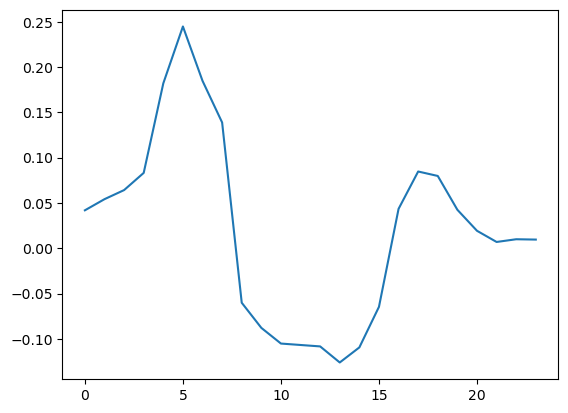

In [65]:
plt.plot(X_vec-aprl_frcast)

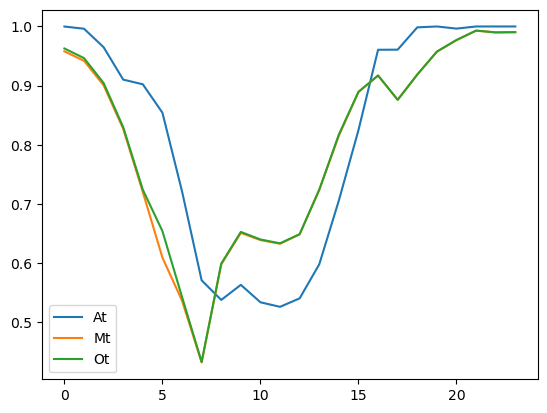

In [54]:
plt.plot(X_vec)
plt.plot(aprl_frcast)
plt.plot(X_vec-B_vec)
plt.legend(["At","Mt","Ot"])


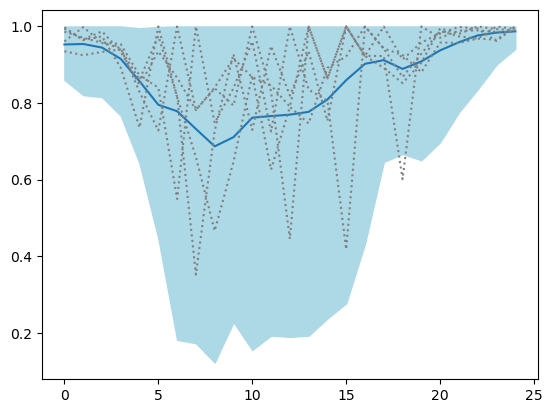

In [24]:
lower,upper = process.CI_95
mean = process.mean_vec.flatten()
plt.plot(np.linspace(0,24,25),mean.flatten())
plt.fill_between(np.linspace(0,24,25),lower, upper, color='lightblue', label='90% CI')
for i in range(5):
    plt.plot(np.linspace(0,24,25),process.sim_trajectories[i+10,:], linestyle='dotted', color='grey')

